In [1]:
#autoreload
%load_ext autoreload
%autoreload 2

import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

import sys
sys.path.append("../../src_clasificacion_vistas/common")

import pycimg

In [2]:
current_file_dir = os.getcwd()
train_results_json="../out_evaluate_patch_224_reanot3/train_scores.json"
val_results_json="../out_evaluate_patch_224_reanot3/val_scores.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    




def create_view_tables(train_data,clases):
    labels=[]
    preds=[]
    imags=[]
    filenames=[]
    for d in train_data:

        filenamejson=d['filename'].replace(".npz",".json")
        scores=d['probs_vistas']
        kk=os.path.join("..",filenamejson)
        npzfilename=kk.replace(".json",".npz")
        imagenes=pycimg.npzread_torch(npzfilename,kk,channel_list=['R','G','B'])
        if not os.path.exists(kk):
            print(" does not exist: ",kk)
            continue
        with open(kk, "r") as f:
            anot_dict = json.load(f)
            
        truth_vistas=anot_dict['views_annotations']
        
        nvistas=len(truth_vistas)
        nclases=len(clases)
        truths=[]
        
        for n in range(nvistas):
            keyid="view_"+str(n)
            truths.append(truth_vistas[keyid])
        for vista in imagenes:
            imags.append(vista.permute(1,2,0)[:,:,:3])
            
        gt=torch.zeros((nvistas,nclases))    
        
        
        # truths: lista de vistas. Cada una de ellas es un diccionario con el nombre del defecto como clave
        for n in range(nvistas):
            for m, defecto in enumerate(clases):
                if defecto in truths[n]:
                    gt[n,m]=float(truths[n][defecto])
                    
        preds1=torch.zeros((nvistas,nclases))
        for n in range(nvistas):
            for m, defecto in enumerate(clases):
                if defecto in scores:
                    preds1[n,m]=float(scores[defecto][n])
        print(gt.shape,preds1.shape)
        labels.append(gt)
        preds.append(preds1)
        filenames+=[filenamejson]*nvistas
            
    labels=torch.concat(labels,axis=0)
    preds=torch.concat(preds,axis=0)

    return preds,labels,filenames,imags



with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

881
443


In [3]:
preds_train,labels_train,filenames_train,imags_train=create_view_tables(train_data,clases)
preds_val,labels_val,filenames_val,imags_val=create_view_tables(val_data,clases)
print(len(filenames_train),len (imags_train))
print(preds_train.shape,labels_train.shape)

torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]

# Cantidad de Vistas de con cada defecto

In [4]:
print("==========================================")
print("  ** VAL **")
print("==========================================")

n_por_defecto=labels_val.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_val.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_val.shape[0])

print("\n==========================================")
print("  ** TRAIN **")
print("==========================================")

n_por_defecto=labels_train.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_train.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_train.shape[0])

  ** VAL **
green : 312
hollow : 154
light_scars : 133
oil_spots : 87
plu_stickers : 55
rotten : 253
scars : 235
skin_breakdown : 104
surface : 933
N sin defectos: 2375
N total: 4427

  ** TRAIN **
green : 410
hollow : 277
light_scars : 373
oil_spots : 244
plu_stickers : 104
rotten : 425
scars : 254
skin_breakdown : 287
surface : 2154
N sin defectos: 4024
N total: 8158


# Análisis AUROC por categorías por vistas

In [5]:
f_auroc=AUROC(task='multilabel',num_labels=len(clases),average='none')
res=f_auroc(preds_val,labels_val.int())
res=res.tolist()

aucs={}
for c,auc in zip(clases,res):
    aucs[c]=auc
    print(f'AUC-val({c}) : {auc:.3f}')


AUC-val(green) : 0.958
AUC-val(hollow) : 0.851
AUC-val(light_scars) : 0.955
AUC-val(oil_spots) : 0.952
AUC-val(plu_stickers) : 1.000
AUC-val(rotten) : 0.949
AUC-val(scars) : 0.955
AUC-val(skin_breakdown) : 0.937
AUC-val(surface) : 0.918


# Histogramas de probabilidades por clase

## Validación

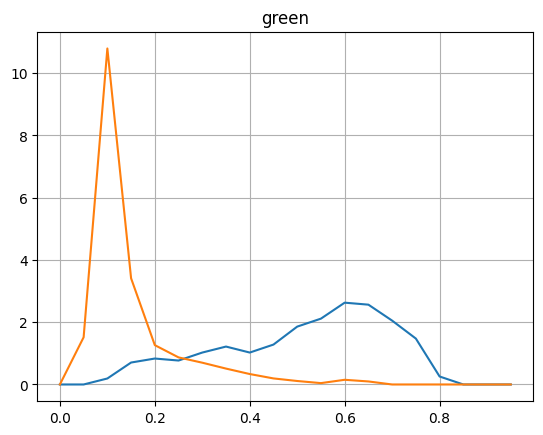

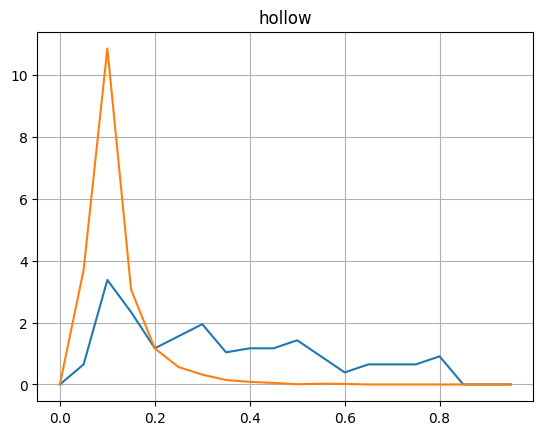

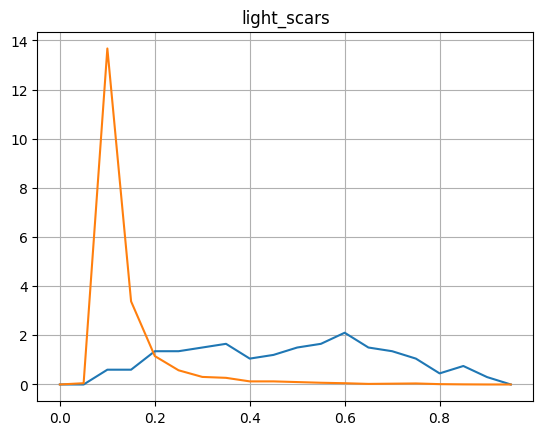

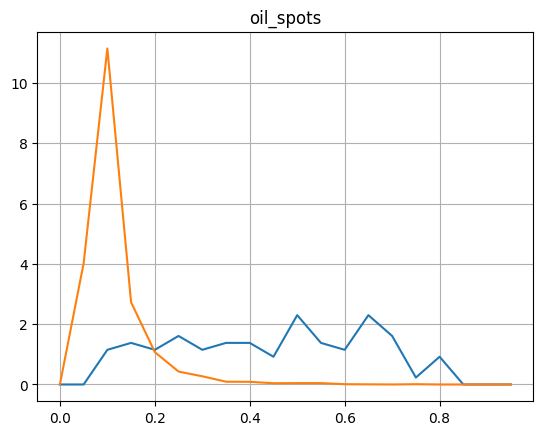

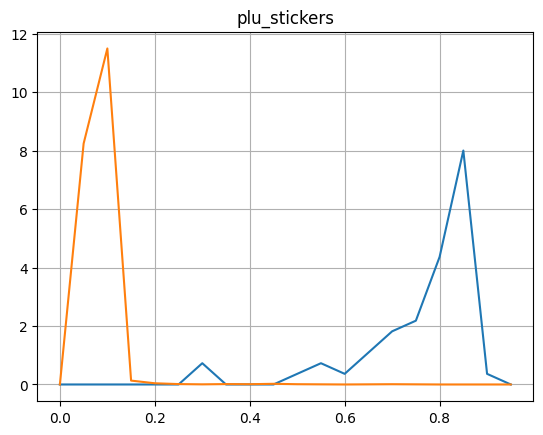

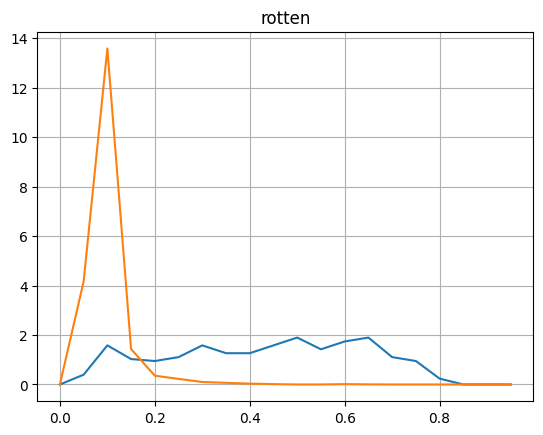

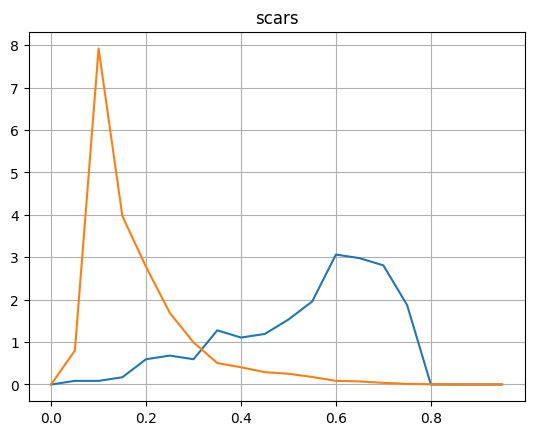

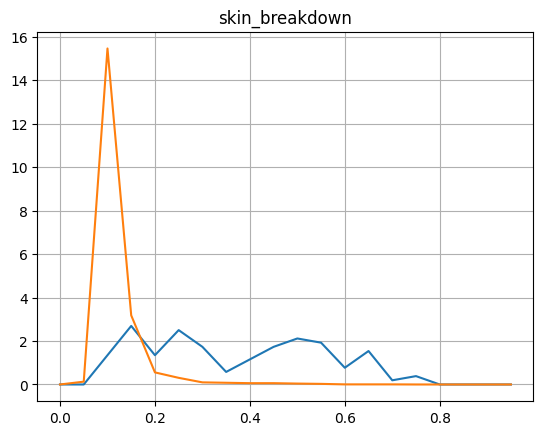

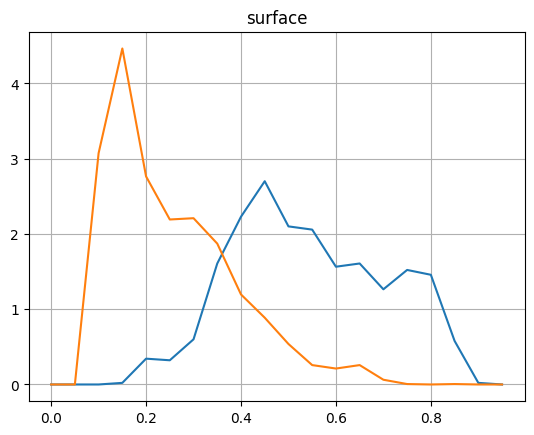

In [6]:
for id_clase in range(len(clases)):
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]

    target_pos=t[t>0.5]
    pred_pos=prob[t>0.5]

    target_neg=t[t<0.5]
    pred_neg=prob[t<0.5]

    
    hh=np.ones(1)/1
    hpos,e=np.histogram(pred_pos,bins=20,range=(0.0,1.0),density=True)
    hneg,f=np.histogram(pred_neg,bins=20,range=(0.0,1.0),density=True)
    
    hpos=np.convolve(hpos, hh, 'same')
    hneg=np.convolve(hneg, hh, 'same')
    _=plt.figure()
    _=plt.plot(e[:-1],hpos)
    _=plt.plot(f[:-1],hneg)
    _=plt.title(clases[id_clase])
    _=plt.grid()

# Seleccionar vistas sospechosas en bueno

In [7]:
# preds_train,labels_train,filenames_train,imags_train
# preds_val,labels_val,filenames_val,imags_val

preds_all=np.concatenate((preds_train,preds_val),axis=0)
labels_all=np.concatenate((labels_train,labels_val),axis=0)
filenames_all=filenames_train+filenames_val
imags_all=imags_train+imags_val

In [8]:
casos_buenos=np.max(labels_all,axis=1)<0.5
casos_buenos_idx=np.argwhere(casos_buenos)[:,0]
print(casos_buenos.shape)
print(casos_buenos_idx.shape)

preds_buenos=preds_all[casos_buenos_idx,:]
labels_buenos=labels_all[casos_buenos_idx,:]
imags_buenos=[imags_all[k] for k in casos_buenos_idx]
filenames_buenos=[filenames_all[k] for k in casos_buenos_idx]
defectuosidad_buenos=np.max(preds_buenos[:,1:],axis=1)

idx_sort=np.argsort(defectuosidad_buenos)[::-1]

(12585,)
(6399,)


In [9]:
from matplotlib.backends.backend_pdf import PdfPages

bce=torch.nn.BCELoss(reduction='none')
print(preds_all.shape,labels_all.shape)

pred_tensor=torch.tensor(preds_all)
label_tensor=torch.tensor(labels_all)
print(pred_tensor.shape,label_tensor.shape)

loss=bce(torch.tensor(preds_all[:,:]),torch.tensor(labels_all[:,:]))
print(loss.shape)
loss=loss.mean(axis=1).numpy()

idx_sort=np.argsort(loss)[::-1]



nombres_cortos=[c[:6] for c in clases]

numpaginas=300
umbral_defectuosidad = 0.1
defectuosidad=loss


selected_files=[]
selected_preds=[]
selected_labels=[]
selected_imags=[]

selected_basenames=[]
selected_defectuosidad=[]



for i in range(len(idx_sort)):
    
        idx=idx_sort[i]
        if i > numpaginas or defectuosidad[idx] < umbral_defectuosidad:
            break     
        filename=filenames_all[idx]
        pred=preds_all[idx]
        lab=labels_all[idx]
        imag=imags_all[idx]
        selected_files.append(filename)
        selected_preds.append(pred)
        selected_labels.append(lab)
        selected_imags.append(imag)
        basename=os.path.basename(filename)
        selected_basenames.append(basename)
        selected_defectuosidad.append(defectuosidad[idx])
        
print("Defectuosidad minima= ",min(selected_defectuosidad))
print("Numpages=",len(selected_files))        
        
with PdfPages('bce_views_sort_defect.pdf') as pdf :
    for idx in range(len(selected_defectuosidad)): # Estos están ordenados por defectuosidad
        
        filename=selected_files[idx]
        pred=selected_preds[idx]
        lab=selected_labels[idx]
        fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})
        pos = axes[0].get_position()
        axes[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
        axes[0].bar(nombres_cortos,lab)
        axes[0].bar(nombres_cortos,pred)

        
        axes[0].tick_params(axis='x',rotation=90)
        axes[0].set_ylim([0,1])


        axes[1].imshow(selected_imags[idx])
        axes[1].axis('off')
        axes[1].set_title(f'{selected_basenames[idx]} - {selected_defectuosidad[idx]:.3f}')
        
        
        pdf.savefig(fig)
        plt.close(fig)
   
        
idx_sort2=np.argsort(selected_basenames)
        

with PdfPages('bce_views_alph.pdf') as pdf :
    for i in range(len(idx_sort2)):
        idx=idx_sort2[i]
        filename=selected_files[idx]
        pred=selected_preds[idx]
        lab=selected_labels[idx]
        fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})
        pos = axes[0].get_position()
        axes[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
        axes[0].bar(nombres_cortos,lab)
        axes[0].bar(nombres_cortos,pred)

        
        axes[0].tick_params(axis='x',rotation=90)
        axes[0].set_ylim([0,1])


        axes[1].imshow(selected_imags[idx])
        axes[1].axis('off')
        axes[1].set_title(f'{selected_basenames[idx]} - {selected_defectuosidad[idx]:.3f}')
        
        
        pdf.savefig(fig)
        plt.close(fig)


(12585, 9) (12585, 9)
torch.Size([12585, 9]) torch.Size([12585, 9])
torch.Size([12585, 9])
Defectuosidad minima=  0.3663623
Numpages= 301


In [10]:
print(len(selected_basenames))

print(selected_files[:5])
lista_selected_jsons=list(set(selected_files))
lista_selected_jsons.sort()
print(len(lista_selected_jsons))
print(lista_selected_jsons[:5])

lista_pngs=[f.replace(".json",".png") for f in lista_selected_jsons]

print(lista_pngs[:5])


301
['data/mandarins/nardocot/manfredi/20250220_1248_000168.json', 'data/mandarins/clementine/KDC/20220803_231126_CLEMENTINE_Encoder_Scar/20250217_1713_002054.json', 'data/mandarins/clementine/KDC/20220804_221439_CLEMENTINE_ENCODER_Hollow/20250218_1113_000465.json', 'data/mandarins/clementine/KDC/20220804_221439_CLEMENTINE_ENCODER_Hollow/20250218_1113_000465.json', 'data/mandarins/clementine/KDC/20220804_221439_CLEMENTINE_ENCODER_Hollow/20250218_1113_000465.json']
148
['data/mandarins/clementine/KDC/20220803_230515_CLEMENTINE_Encoder_Creasing1/20250218_0851_000161.json', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1640_000001.json', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1640_002002.json', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000002.json', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000004.json']
['data/mandarins/clementine/KD

[0.24741663 0.28656513 0.32642843 0.35497758 0.41470015]


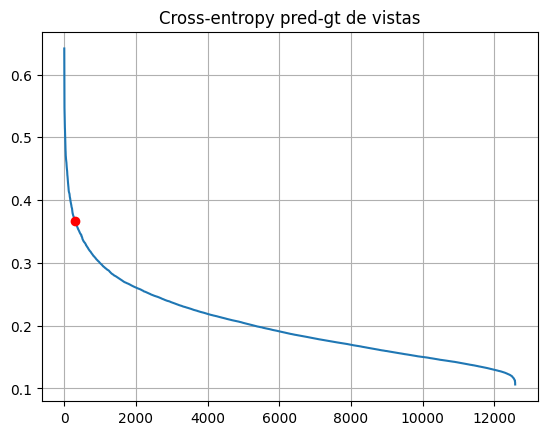

In [11]:
sorted_defectuosidad=np.sort(defectuosidad)[::-1]


_=plt.plot(sorted_defectuosidad)
#_=plt.xlim([0,2000])
_=plt.grid()
_=plt.title("Cross-entropy pred-gt de vistas")
_=plt.plot(300,sorted_defectuosidad[300],'ro')

print(np.percentile(sorted_defectuosidad,[80, 90,95,97,99]))

In [13]:
# Copiar los pngs a un directorio
import shutil

target_dir='/home/aalbiol/Desktop/reanot3_results/imags'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for png in lista_pngs:
    pngrel=os.path.join("../",png)
    jsonrel=pngrel.replace(".png",".json")
    shutil.copy(pngrel,target_dir)
    shutil.copy(jsonrel,target_dir)